# Stabilization using sBs Protocol
Dimensionless Hamiltonian simulation of sBs with loss.

## Imports + Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from bosonic import Qubit, GKPQubit, BosonicRegister, BosonicCircuit, CDGate, QubitRotationGate

from bosonic import execute
import jaxquantum as jqt
import jax.numpy as jnp
from jax import jit, vmap, lax, config
from functools import partial

config.update("jax_enable_x64", True)

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from tqdm import tqdm

## Initialize Bosonic Circuit

In [3]:
"""Circuit containing 1 cavity and 1 qubit"""
N = 100
breg = BosonicRegister([GKPQubit({"N": N, "delta": 0.3}),Qubit()])
bcirc = BosonicCircuit(breg)

"""GKP + Stabilization Params"""
l = bcirc.breg[0].params["l"]
Δ = bcirc.breg[0].params["delta"]
c = jnp.cosh(Δ**2)
epsilon = bcirc.breg[0].params["epsilon"]


"""Useful Qubit Operators"""
ρ_qubit_g = jnp.array([[1.0, 0.0], [0.0, 0.0]])
ρ_qubit_e = jnp.array([[0.0, 0.0], [0.0, 1.0]])
ρ_qubit_plus = 0.5 * jnp.array([[1.0, 1.0], [1.0, 1.0]])
I_q = jqt.identity(2)


"""Useful Cavity Operators"""
ρ_cavity_vac = jqt.ket2dm(jqt.basis(N, 0))

I_a = jqt.identity(N)
a = jqt.destroy(N)
q_a = +1 * (a + jqt.dag(a)) / jnp.sqrt(2)
p_a = -1j * (a - jqt.dag(a)) / jnp.sqrt(2)



"""sBs Phase Estimation Unitaries"""
M_z = jqt.expm(jqt.tensor(-1j * l * c * q_a / 4, jqt.sigmax())) @ jqt.expm(jqt.tensor(-1j * epsilon * p_a / 4, jqt.sigmay()))

M_x = jqt.expm(jqt.tensor(-1j * l * c * p_a / 4, jqt.sigmax())) @ jqt.expm(jqt.tensor(+1j * epsilon * q_a / 4, jqt.sigmay()))

M_y = jqt.expm(jqt.tensor(-1j * l * c * (q_a + p_a) / 4, jqt.sigmax())) @ jqt.expm(jqt.tensor(-1j * epsilon * (p_a - q_a) / 4, jqt.sigmay()))

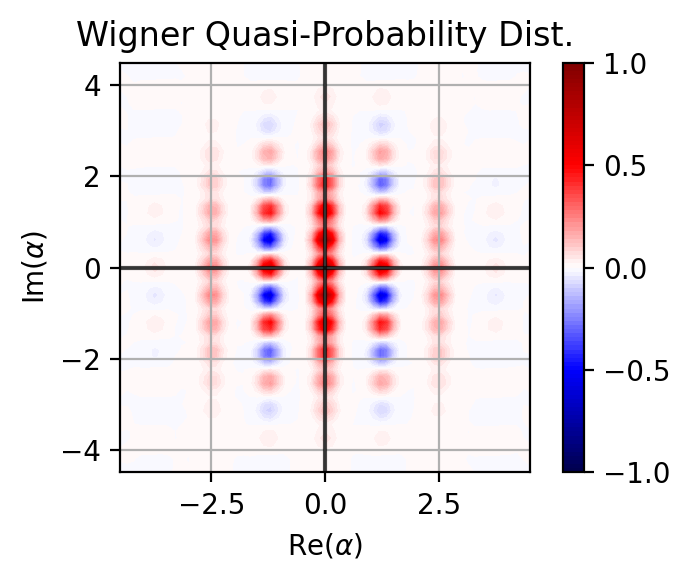

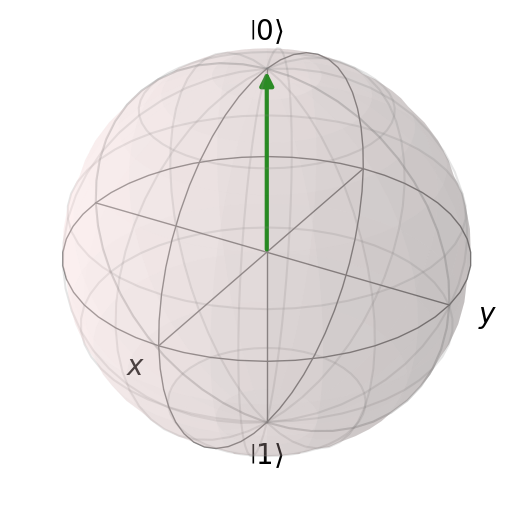

<Figure size 640x480 with 0 Axes>

In [4]:
bcirc.reset()
bcirc.plot(0)
bcirc.plot(1)

## Stabilization Circuit

In [5]:
def sBs(breg: BosonicRegister, epsilon: float, l: float, qp: float, backend: str = "unitary"):
    
    bcirc = BosonicCircuit(breg)
    if backend == "unitary" or backend == "unitary_jax":
        bcirc.add(CDGate, (0, 1), params={"beta": qp * epsilon / 2})
        bcirc.add(QubitRotationGate, (1), params={"theta": np.pi / 2})
        bcirc.add(CDGate, (0, 1), params={"beta": -1.0j * qp * l})
        bcirc.add(QubitRotationGate, (1), params={"theta": -np.pi / 2})
        bcirc.add(CDGate, (0, 1), params={"beta": qp * epsilon / 2})
        #bcirc.add(QubitRotationGate, (1), params={"theta": -np.pi})
    
    elif backend == "hamiltonian" or backend == "hamiltonian_jax":
        bcirc.add(CDGate, (0, 1), params={"beta": qp * epsilon / 2}, ts = jnp.linspace(0, 1, 101))
        bcirc.add(QubitRotationGate, (1), params={"omega": 1, "theta": jnp.pi/2}, ts = jnp.linspace(0, jnp.pi / 2, 101))
        bcirc.add(CDGate, (0, 1), params={"beta": -1.0j * qp * l}, ts = jnp.linspace(0, 1, 101))
        bcirc.add(QubitRotationGate, (1), params={"omega": -1, "theta": -jnp.pi/2}, ts = jnp.linspace(0, jnp.pi / 2, 101))
        bcirc.add(CDGate, (0, 1), params={"beta": qp * epsilon / 2}, ts = jnp.linspace(0, 1, 101))
        #bcirc.add(QubitRotationGate, (1), params={"omega": -1, "theta": -np.pi}, ts = np.linspace(0, np.pi, 101))
    
    return bcirc

In [6]:
def sBs_stabilize_jax(
    bcirc_x: BosonicCircuit,
    bcirc_p: BosonicCircuit,
    N_rounds: int,
    backend: str,
    p0=None,
    meas_ops=[],
    resource_states=None,
    store_states: bool=False,
    store_qt_results: bool=False,
    **kwargs,
):
    """
    Function to implement the sBs GKP stabilization protocol, as described in the reference:
    B. Royer, et. al. "Stabilization of Finite-Energy Gottesman-Kitaev-Preskill States" (2020).

    We assume the input BosonicCircuits have a register of the form [GKPQubit, Qubit], with the
    GKPQubit in index 0. Therefore, we use rho.ptrace(0) to extract the oscillator state.


    Arguments:
        bcirc_x: BosonicCircuit for single run of sBs to stabilize in X
        bcirc_p: BosonicCircuit for single run of sBs to stabilize in P
        N_rounds: Number of stabilization rounds. Each round consists of 2 sBs runs (both X and P)
        backend: Simulator backend: "unitary" or "hamiltonian"
        p0: Initial cavity state to stabilize.
        meas_ops:
                List of phase-estimation measurement operators [Mx, My, Mz].
                If empty or None, then we will measure the logicals of GKP.
                TODO:
                    We should switch to a meas_circ and meas_op approach,
                    so that we can account for measurement loss.
        store_states: Flag to return the stored density matrix after each sBs
        store_qt_results: Flag to return raw qutip mesolve results

    Returns:
        meas_results: Array of expectation values with dimension len(meas_ops) × len(N_rounds)
    """

    if p0 is not None:
        rho = p0
    else:
        rho = bcirc_x.gen_default_initial_state()

    """
    Note: Here we assume that the GKP Qubit being stabilized has idx 0. 
    This allows us to use rho.ptrace(0) to extract just the GKP state.
    """
    GKP = bcirc_x.breg.bqubits[0]
    N = GKP.params["N"]
    resource_states = {} if resource_states is None else resource_states

    meas_logicals = True if len(meas_ops) == 0 else False
    # not bool(meas_ops)  # measure logicals if meas_ops empty
    meas_ops = jnp.array([GKP.x_U, GKP.y_U, GKP.z_U]) if meas_logicals else jnp.asarray(meas_ops)
    # meas_results = jnp.zeros([len(meas_ops), N_rounds]) * 1j

    plus = resource_states.get(
        "plus", jqt.ket2dm(1 / jnp.sqrt(2) * (jqt.basis(2, 0) + jqt.basis(2, 1)))
    )  # Qubit |+>

    single_qubit_g = resource_states.get(
        "single_qubit_g", jqt.ket2dm(jqt.basis(2, 0))
    )  # Qubit |g><g|

    sBs_states = [rho] if store_states else None
    qt_results = [] if store_qt_results else None

    
    @jit
    def calc_meas_logicals(M, rho):
        return jnp.trace(M @ jqt.ptrace(rho, 0, (N, 2)))

    @jit
    def calc_phase_est(M, rho):
        psi_meas = M @ jqt.tensor(jqt.ptrace(rho, 0, (N, 2)), single_qubit_g) @ jqt.dag(M)
        return jnp.trace(psi_meas @ jqt.tensor(jqt.identity(N), jqt.sigmaz()))
    
    meas_results = []
    
    for stab_round in tqdm(range(N_rounds)):
        # Measure first in the initial state before stabilizing
        
        if meas_logicals:
            meas_results.append(vmap(calc_meas_logicals, in_axes=(0, None))(meas_ops, rho))
        else:
            meas_results.append(vmap(calc_phase_est, in_axes=(0, None))(meas_ops, rho))


        # Initialize ancilla to |+>, then stabilize X
        result = execute(bcirc_x, backend, p0=jqt.tensor(jqt.ptrace(rho, 0, (N, 2)), plus), **kwargs)
        rho = result.results[-1]['states'][-1]        

        if store_states:
            sBs_states.append(rho)
        if store_qt_results:
            qt_results.extend(result)

        # Reset ancilla to |+>, then stabilize P
        result = execute(bcirc_p, backend, p0=jqt.tensor(jqt.ptrace(rho, 0, (N, 2)), plus), **kwargs)
        rho = result.results[-1]['states'][-1]

        if store_states:
            sBs_states.append(rho)
        if store_qt_results:
            qt_results.extend(result)

    # Return
    if store_states and store_qt_results:
        return meas_results, sBs_states, qt_results
    elif store_states:
        return meas_results, sBs_states
    elif store_qt_results:
        return meas_results, qt_results
    else:
        return meas_results

In [10]:
@partial(jit, static_argnames=("breg", "store_states", "N_rounds"))
def sBs_stabilize_unitary_jax(
    breg: BosonicRegister,
    N_rounds: int,
    p0=None,
    meas_ops=[],
    resource_states=None,
    store_states: bool=False,
    **kwargs,
):
    """
    Function to implement the sBs GKP stabilization protocol, as described in the reference:
    B. Royer, et. al. "Stabilization of Finite-Energy Gottesman-Kitaev-Preskill States" (2020).

    We assume the input BosonicCircuits have a register of the form [GKPQubit, Qubit], with the
    GKPQubit in index 0. Therefore, we use rho.ptrace(0) to extract the oscillator state.


    Arguments:
        bcirc_x: BosonicCircuit for single run of sBs to stabilize in X
        bcirc_p: BosonicCircuit for single run of sBs to stabilize in P
        N_rounds: Number of stabilization rounds. Each round consists of 2 sBs runs (both X and P)
        backend: Simulator backend: "unitary" or "hamiltonian"
        p0: Initial cavity state to stabilize.
        meas_ops:
                List of phase-estimation measurement operators [Mx, My, Mz].
                If empty or None, then we will measure the logicals of GKP.
                TODO:
                    We should switch to a meas_circ and meas_op approach,
                    so that we can account for measurement loss.
        store_states: Flag to return the stored density matrix after each sBs
        store_qt_results: Flag to return raw qutip mesolve results

    Returns:
        meas_results: Array of expectation values with dimension len(meas_ops) × len(N_rounds)
    """

    # Define the two sBs circuits
    bcirc_x = sBs(breg, epsilon, l, 1.0, "unitary_jax")
    bcirc_p = sBs(breg, epsilon, l, 1.0j, "unitary_jax")
    
    
    
    if p0 is not None:
        rho = p0
    else:
        rho = bcirc_x.gen_default_initial_state()

    """
    Note: Here we assume that the GKP Qubit being stabilized has idx 0. 
    This allows us to use rho.ptrace(0) to extract just the GKP state.
    """
    GKP = bcirc_x.breg.bqubits[0]
    N = GKP.params["N"]
    resource_states = {} if resource_states is None else resource_states

    meas_logicals = True if len(meas_ops) == 0 else False
    # not bool(meas_ops)  # measure logicals if meas_ops empty
    meas_ops = jnp.array([GKP.x_U, GKP.y_U, GKP.z_U]) if meas_logicals else jnp.asarray(meas_ops)
    # meas_results = jnp.zeros([len(meas_ops), N_rounds]) * 1j

    plus = resource_states.get(
        "plus", jqt.ket2dm(1 / jnp.sqrt(2) * (jqt.basis(2, 0) + jqt.basis(2, 1)))
    )  # Qubit |+>

    single_qubit_g = resource_states.get(
        "single_qubit_g", jqt.ket2dm(jqt.basis(2, 0))
    )  # Qubit |g><g|

    sBs_states = [rho] if store_states else None

    
    @jit
    def calc_meas_logicals(M, rho):
        return jnp.trace(M @ jqt.ptrace(rho, 0, (N, 2)))

    @jit
    def calc_phase_est(M, rho):
        psi_meas = M @ jqt.tensor(jqt.ptrace(rho, 0, (N, 2)), single_qubit_g) @ jqt.dag(M)
        return jnp.trace(psi_meas @ jqt.tensor(jqt.identity(N), jqt.sigmaz()))
    
    meas_results = []
    
    for stab_round in range(N_rounds):
        # Measure first in the initial state before stabilizing
        
        if meas_logicals:
            meas_results.append(vmap(calc_meas_logicals, in_axes=(0, None))(meas_ops, rho))
        else:
            meas_results.append(vmap(calc_phase_est, in_axes=(0, None))(meas_ops, rho))


        # Initialize ancilla to |+>, then stabilize X
        result = execute(bcirc_x, "unitary_jax", p0=jqt.tensor(jqt.ptrace(rho, 0, (N, 2)), plus), **kwargs)
        rho = result.results[-1]['states'][-1]        

        if store_states:
            sBs_states.append(rho)

        # Reset ancilla to |+>, then stabilize P
        result = execute(bcirc_p, "unitary_jax", p0=jqt.tensor(jqt.ptrace(rho, 0, (N, 2)), plus), **kwargs)
        rho = result.results[-1]['states'][-1]

        if store_states:
            sBs_states.append(rho)

    # Return
    if store_states:
        return meas_results, sBs_states
    else:
        return meas_results

In [28]:
def sbs_unitary_jax_carry(breg, N_rounds, p0, backend):

    bcirc_x = sBs(breg, epsilon, l, 1.0, backend)
    bcirc_p = sBs(breg, epsilon, l, 1.0j, backend)

    def sbs_one_round(p0, n):
        result = execute(bcirc_x, backend, p0=p0)
        rho = result.results[-1]['states'][-1]
        result = execute(bcirc_p, backend, p0=rho)
        rho = result.results[-1]['states'][-1]
        return rho
    
    return lax.scan(sbs_one_round, p0, jnp.arange(N_rounds))



    

In [33]:
ρ_qubit_plus

Array([[0.5, 0.5],
       [0.5, 0.5]], dtype=float64)

In [ ]:
sbs_unitary_jax_carry(breg, 1, jqt.tensor(ρ_cavity_vac, ρ_qubit_plus), "unitary_jax")

In [ ]:
bk = "hamiltonian_jax"
stateH = execute(sBs(breg, epsilon, l, 1.0, bk), H0=0j, p0=jqt.tensor(ρ_cavity_vac, ρ_qubit_plus), backend=bk)

In [ ]:
bk = "unitary_jax"
stateU = execute(sBs(breg, epsilon, l, 1.0, bk), H0=0j, p0=jqt.tensor(ρ_cavity_vac, ρ_qubit_plus), backend=bk)

### Direct Measurement of `ZL`

In [ ]:
sBs_stabilize_unitary_jax(
    breg,
    N_rounds=1, 
    # meas_ops=jnp.array([M_x, M_y, M_z]),
    p0=jqt.tensor(ρ_cavity_vac, ρ_qubit_plus), 
    H0=0j, 
    store_states=True,
)

In [ ]:
backend = "unitary_jax"

# Define the two sBs circuits
bcirc_sBs_x = sBs(breg, epsilon, l, 1.0, backend)
bcirc_sBs_p = sBs(breg, epsilon, l, 1.0j, backend)

meas_resultsU, sbs_statesU = sBs_stabilize_jax(
    bcirc_sBs_x, 
    bcirc_sBs_p, 
    N_rounds=21, 
    backend=backend,
    # meas_ops=jnp.array([M_x, M_y, M_z]),
    p0=jqt.tensor(ρ_cavity_vac, ρ_qubit_plus), 
    H0=0j, 
    store_states=True,
)

In [ ]:
meas_results = jnp.array(meas_resultsU)
sbs_states = jnp.array(sbs_statesU)

In [ ]:
@jit
def calc_meas_logicals(M, rho):
    # return dq.tracemm(M, jqt.ptrace(rho, 0, (N, 2)))


    return jnp.trace(M @ jqt.ptrace(rho, 0, (N, 2)))

In [ ]:
zzz = vmap(vmap(calc_meas_logicals, in_axes=(0, None)), in_axes=(None, 0))(jnp.array([breg[0].x_U, breg[0].y_U, breg[0].z_U]), jnp.array(sbs_states))

In [ ]:
plt.plot(jnp.abs(zzz[0::2, 2]))
plt.plot(jnp.abs(meas_results[:, 2]))

In [ ]:
jqt.plot_wigner(jqt.ptrace(sbs_states[-2], 0, (N, 2)), jnp.linspace(-3, 3, 51))

In [ ]:
plt.figure("logicals", dpi=200)
plt.clf()
plt.axhline(0.893, linestyle="dashed", color="lightgray", label="0.893")
plt.plot(np.abs(np.real(meas_results[:, 2])), '.-', label=r"Logical $\langle Z_L \rangle$")
plt.ylim(0, 1.01)
plt.title(fr"{backend.capitalize()} Simulation: $|\psi_0\rangle = D\left(\ell/10\right)|0_L\rangle$", fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.xlabel("# stabilizations", fontsize=14)
plt.xticks(np.arange(0, 20, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r"|Re. $\langle Z_L \rangle$|", fontsize=14)
plt.tight_layout()

### Phase Estimation via sBs `Mz` circuit

In [ ]:
backend = "hamiltonian"

# Define the two sBs circuits
bcirc_sBs_x = sBs(breg, epsilon, l, 1.0, backend)
bcirc_sBs_p = sBs(breg, epsilon, l, 1.0j, backend)

meas_results2 = sBs_stabilize(
    bcirc_sBs_x, 
    bcirc_sBs_p, 
    N_rounds=20, 
    backend=backend, 
    p0=ρdisp, 
    meas_ops=[M_x, M_y, M_z], 
    H0=0j, 
    c_ops=[],
    e_ops=[]
)

In [ ]:
plt.figure("logicals", dpi=200)
plt.clf()
plt.axhline(0.887, linestyle="dashed", color="lightgray")
plt.plot(np.abs(np.real(meas_results2[2, :])), '.-', label=r"Logical $\langle M_z \rangle\,\to$ 0.887")
#plt.ylim(0, 1.01)
plt.title(fr"{backend.capitalize()} Simulation: $|\psi_0\rangle = D\left(\ell/10\right)|0_L\rangle$", fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.xlabel("# stabilizations", fontsize=14)
plt.xticks(np.arange(0, 20, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r"|Re.$\langle Z \rangle$|", fontsize=14)
plt.tight_layout()

## Stabilization with Single Photon Loss $\hat{a}$

In [ ]:
backend = "hamiltonian"

kappas = [1e-2, 7e-3, 5e-3, 3e-3, 1e-3, 1e-4] # Dimensionless Units
meas_results_photon = []

for kappa in kappas:
    # Define the two sBs circuits
    bcirc_sBs_x = sBs(breg, epsilon, l, 1.0, backend)
    bcirc_sBs_p = sBs(breg, epsilon, l, 1.0j, backend)

    meas = sBs_stabilize(
        bcirc_sBs_x, 
        bcirc_sBs_p, 
        N_rounds=21, 
        backend=backend, 
        p0=ρGKP_plusz, 
        meas_ops=[M_x, M_y, M_z], 
        H0=0j, 
        c_ops=[np.sqrt(kappa)*qt.tensor(a, I_q)], 
        e_ops=[]
    )
    
    meas_results_photon.append(meas)

In [ ]:
"""Fit to exponential decay"""

def exp_decay(xs, γ):
    return np.exp(-γ*xs)


import matplotlib.colors as mcolors 
colors = [c for c in mcolors.TABLEAU_COLORS.keys()]

In [ ]:
plt.figure("logicals", dpi=200)
plt.clf()

for i, k in enumerate(kappas):
    plt.plot(np.abs(meas_results_photon[i][2, :]), '.-', label=fr"$\kappa$ = {k}", color=colors[i])
    
    # Fit results
    # popt, pcov = curve_fit(exp_decay, np.arange(0, 21, 1), np.abs(meas_results_photon[i][2, :]))
    # plt.plot(exp_decay(np.arange(0, 21, 1), *popt), '-', label=f"Fitted Logical Decay rate: {popt[0]:.3f}", color=colors[i])
    
plt.title(fr"Stabilization (sBs) w/ Photon Loss $\kappa D(\hat a)$ on $|\psi_0\rangle = |0_L\rangle$", fontsize=12)
plt.xlabel("# stabilizations", fontsize=12)
plt.xticks(np.arange(0, 21, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"Logical |Re.$\langle Z \rangle$|", fontsize=12)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

## Stabilization with Qubit $T_1$ Loss $\sigma_-$ and $\sigma_+$

In [ ]:
backend = "hamiltonian"

rates = [0.2, 0.1, 0.05, 0.01, 1e-3] # Dimensionless units
meas_results_T1 = []

for rate in rates:
    # Define the two sBs circuits
    bcirc_sBs_x = sBs(breg, epsilon, l, 1.0, backend)
    bcirc_sBs_p = sBs(breg, epsilon, l, 1.0j, backend)

    meas = sBs_stabilize(
        bcirc_sBs_x, 
        bcirc_sBs_p, 
        N_rounds=21, 
        backend=backend, 
        p0=ρGKP_plusz, 
        meas_ops=[M_x, M_y, M_z], 
        H0=0j, 
        c_ops=[np.sqrt(rate)*qt.tensor(I_a, qt.sigmam())], 
        e_ops=[]
    )
    
    meas_results_T1.append(meas)

### Plot Logicals 

In [ ]:
plt.figure("logicals", dpi=200)
plt.clf()
for i, r in enumerate(rates): 
    plt.plot(np.abs(meas_results_T1[i][2, :]), '.', label=fr"$\gamma$ = {r}")

    # Fit results
    popt, pcov = curve_fit(exp_decay, np.arange(0, 21, 1), np.abs(meas_results_T1[i][2, :]))
    plt.plot(exp_decay(np.arange(0, 21, 1), *popt), '-', label=f"Logical Decay Fitted: {popt[0]:.3f}", color=colors[i])



plt.title(fr"Stabilization (sBs) w/ Qubit $T_1$ Loss $\gamma D(\hat \sigma_-)$ on $|\psi_0\rangle = |0_L\rangle$", fontsize=12)
plt.xlabel("# stabilizations", fontsize=12)
plt.xticks(np.arange(0, 21, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"Logical |Re. $\langle Z \rangle$|", fontsize=12)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

### Rescale Times

In [ ]:
χ = 2 * np.pi * 1  # Qubit-Cavity Chi in 2π × MHz
τ_pi = 0.05   # Qubit (Amp. Rabi) Pi Pulse time (50ns) in μs
τ_CD = np.pi / χ    # CD Gate Time in μs

# Time for a single run of sBs
δt = 3*τ_CD + 2*τ_pi

# Time for one "stabilization" (i.e. sBs x and p)
T_stab = 2*δt

tlist = T_stab*np.arange(0, 21, 1)

In [ ]:
QubitT1s = [np.pi/r for r in rates]
LogicalT1s = []

In [ ]:
plt.figure("logicals", dpi=220)
plt.clf()
for i, t in enumerate(QubitT1s): 
    plt.plot(tlist, np.abs(meas_results_T1[i][2, :]), '.', label=fr"Qubit $T_1$ = {t:.1f} μs")

    # Fit results
    popt, pcov = curve_fit(exp_decay, tlist, np.abs(meas_results_T1[i][2, :]))
    t1 = 1 / popt[0]
    LogicalT1s.append(t1)
    plt.plot(tlist, exp_decay(tlist, *popt), '-', label=f"Logical $T_1$ (fit): {t1:.1f} μs", color=colors[i])



plt.title(fr"Stabilization (sBs) w/ Qubit $T_1$ Loss $\gamma D(\hat \sigma_-)$ on $|\psi_0\rangle = |0_L\rangle$", fontsize=12)
plt.xlabel(r"Time $t$ (μs)", fontsize=12)
#plt.xticks(np.arange(0, 21, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"Logical |Re. $\langle Z \rangle$|", fontsize=12)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

In [ ]:
D = 0.25

(1/δt) * np.tanh(D**2) * (l * np.cosh(D**2) / 2)**2

In [ ]:
δt = 0.5*3 + 0.05*2